In [2]:
%matplotlib inline

import sys
import os
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib
from matplotlib import pyplot as plt, animation, rc,colors
from datetime import datetime, timedelta
from cartopy import crs, feature
import cmocean
import yaml

from IPython.display import Image
rc('animation', html='html5')

sys.path.append('/home/jvalenti/MOAD/analysis-jose/Source')
from OP_functions import *

In [3]:
conc=xr.open_dataarray('/home/jvalenti/MOAD/results/Fraser_long_prob.nc')
local = 0 #Set to 0 when working on server
paths = path(local)
coords = xr.open_dataset(paths['coords'], decode_times=False)
mask = xr.open_dataset(paths['mask'])
Dat=xr.open_dataset(paths['coords'],decode_times=False)
outf_lat=Dat['nav_lat'][445,304]
outf_lon=Dat['nav_lon'][445,304]
clon, clat = [float(outf_lon)],[float(outf_lat)]


FileNotFoundError: [Errno 2] No such file or directory: b'/home/jvalenti/MOAD/results/Fraser_long_prob.nc'

In [4]:
mask.gdepw_0[0,:,240,340]

<xarray.DataArray 'gdepw_0' (z: 40)>
array([  0.      ,   1.000001,   2.000006,   3.000019,   4.000047,   5.000104,
         6.000217,   7.000441,   8.000879,   9.001736,  10.003407,  11.006662,
        12.013008,  13.025366,  14.049429,  15.096255,  16.187304,  17.364035,
        18.705973,  20.363474,  22.613064,  25.937412,  31.101034,  39.11886 ,
        50.963238,  67.05207 ,  86.96747 , 109.73707 , 134.34593 , 160.02956 ,
       186.30528 , 212.89656 , 239.65305 , 266.4952  , 293.3816  , 320.29077 ,
       347.2116  , 374.1385  , 401.06845 , 428.      ], dtype=float32)
Dimensions without coordinates: z
Attributes:
    standard_name:  gdepw_0
    long_name:      depth of W-grid points
    units:          m
    positive:       down

In [5]:
def mapanimation(file,clon,clat,fps=1,local=1):
    
    def update(frame): 
        plt.clf()
        ax = plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))
        t = ax.text(0.02, 0.02, '', transform=ax.transAxes)
        t.set_text('')
        tstamp = file.time[frame].values.astype('datetime64[s]').astype(datetime)
        #print(tstamp)
        t.set_text(tstamp)
        ss = []
        ss.append(ax.contourf(coords.nav_lon, coords.nav_lat, file[frame,:,:],levels=np.arange(1,30,2),cmap=cmocean.cm.dense))
        ax.contour(coords.nav_lon, coords.nav_lat, mask.mbathy[0,:,:],colors='k',linewidths=0.1)
        ax.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
        ax.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
        ax.grid()
        axs.set_aspect(1/np.sin(np.deg2rad(49)))
        plt.ylabel('Latitude',fontsize=16)
        plt.xlabel('Longitude',fontsize=16)
        return fig
        
    #scatter_particles(ax, N,n, 0,0, ds.lat,ds.lon)
    #sed= {0: "w", 1: "k"}


    return animation.FuncAnimation(fig, update, frames=np.arange(0,file.shape[0],fps))

In [6]:
conc

<xarray.DataArray 'Prob' (x: 898, y: 398)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    lat      (x, y) float32 ...
    lon      (x, y) float32 ...
Dimensions without coordinates: x, y

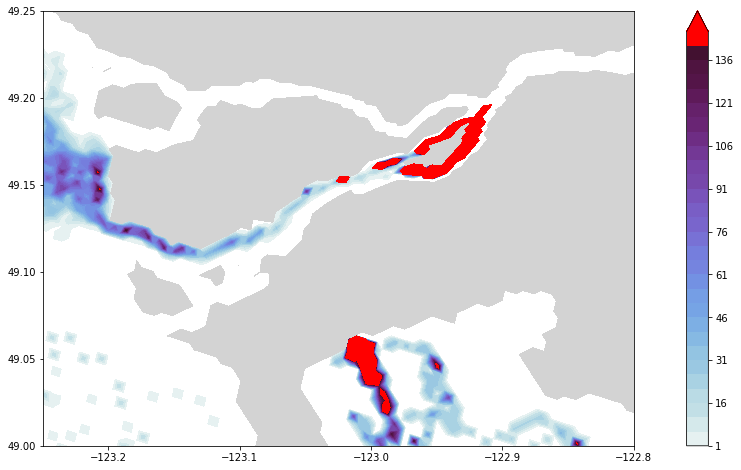

In [5]:
cend=conc*(2118/5)*(3600/3.156e7)/10
fig = plt.figure(figsize=(19, 8))
axs = plt.axes(xlim=(-123.25,-122.8),ylim=(49,49.25))


levels = np.linspace(1,800,50)

colors = list(cmocean.cm.dense(np.linspace(0,1,len(levels)-1)))
colors[-1] = "red"
cmap = matplotlib.colors.ListedColormap(colors,"", len(colors))

#axs=plt.axes(xlim=(-125,-122.5),ylim=(48.5,49.7))

#axs.contourf(coords.nav_lon, coords.nav_lat, 10*mask.mbathy[0,:,:],levels=np.arange(0,400,10),cmap=cmocean.cm.deep,alpha=1)
a=axs.contourf(coords.nav_lon, coords.nav_lat, cend,levels=np.arange(1,150,5),cmap=cmap,extend='max')
#axs.scatter(frs_lon,frs_lat)
axs.contourf(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='lightgray')
#axs.contour(coords.nav_lon, coords.nav_lat, mask.tmask[0, 0, ...], levels=[-0.01, 0.01], colors='k')
plt.colorbar(a)

axs.set_aspect(1/np.sin(np.deg2rad(49)))

In [84]:
def checkgrid(lat,lon):
    jjii = xr.open_dataset('~/MOAD/grid/grid/grid_from_lat_lon_mask999.nc')
    j = jjii.jj.sel(lats=lat, lons=lon, method='nearest').item()
    i = jjii.ii.sel(lats=lat, lons=lon, method='nearest').item()
    return j,i
j,i=checkgrid(49.109463, -123.137744)
cend[j,i]

<xarray.DataArray 'Prob' ()>
array(37.2419999)
Coordinates:
    lat      float32 ...
    lon      float32 ...

In [82]:
# fig = plt.figure(figsize=(19, 8))
# anim = mapanimation(conc,clon,clat,fps=1)
# f = r"/home/jvalenti/MOAD/animations/Fraser2.gif" 
# FFwriter = animation.FFMpegWriter()
# anim.save(f, writer = FFwriter)

In [83]:
#  with open(f,'rb') as anim:
#     display(Image(anim.read()))